 # MVPA
 based on https://peerherholz.github.io/workshop_weizmann/advanced/machine_learning_nilearn.html

In [2]:
import numpy as np
import nibabel as nb
import os
from nilearn.input_data import NiftiMasker

In [3]:
# define paths
root_dir = '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2'
fmriprep_dir = os.path.join(root_dir, 'derivatives', 'fmriprep23')
dataset_dir  = os.path.join(root_dir, 'derivatives', 'mvpa_01_musicnoise')

# brain masks
#mask_brain_file = os.path.join(root_dir, 'derivatives', 'mni_icbm152_t1_tal_nlin_asym_09c.nii')
mask_gm_file    = os.path.join(root_dir, 'derivatives', 'mni_icbm152_gm_tal_nlin_asym_09c_res-2_dilated.nii')

In [4]:
# list datasets and concatenate

# find all *_dataset.nii.gz files in dataset_dir
dataset_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('_musicnoise_confounds_dataset.nii.gz') & f.startswith('sub-')]
dataset_files.sort()

# find all *_trial_types.txt files in dataset_dir
label_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('_musicnoise_confounds_trial_types.txt') & f.startswith('sub-')]
label_files.sort()

In [5]:
# concatenate all datasets
D = nb.concat_images(dataset_files, axis=3)

In [6]:
# concatenate all labels into a single string array
labels = np.concatenate([np.loadtxt(l, dtype=str) for l in label_files])

# trim each label to remove the 2 digit number in the end
labels = np.array([l[:-2] for l in labels])

In [7]:
# Load mask
masker = NiftiMasker(mask_img=mask_gm_file, standardize=False, detrend=False)
samples = masker.fit_transform(D)

In [31]:
# generate an array of chunk labels
# 13 subjects, 10 noise and 9 x 2 music for each of the 4 runs
chunks = np.repeat(np.arange(1,14), 10*4 + 9*2*4)

In [34]:
# Let's specify the classifier
from sklearn.svm import LinearSVC
clf = LinearSVC(multi_class="ovr", max_iter=1000, class_weight='balanced', dual='auto')

## Manual Leave One Subject Out Cross Validation

/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` expli

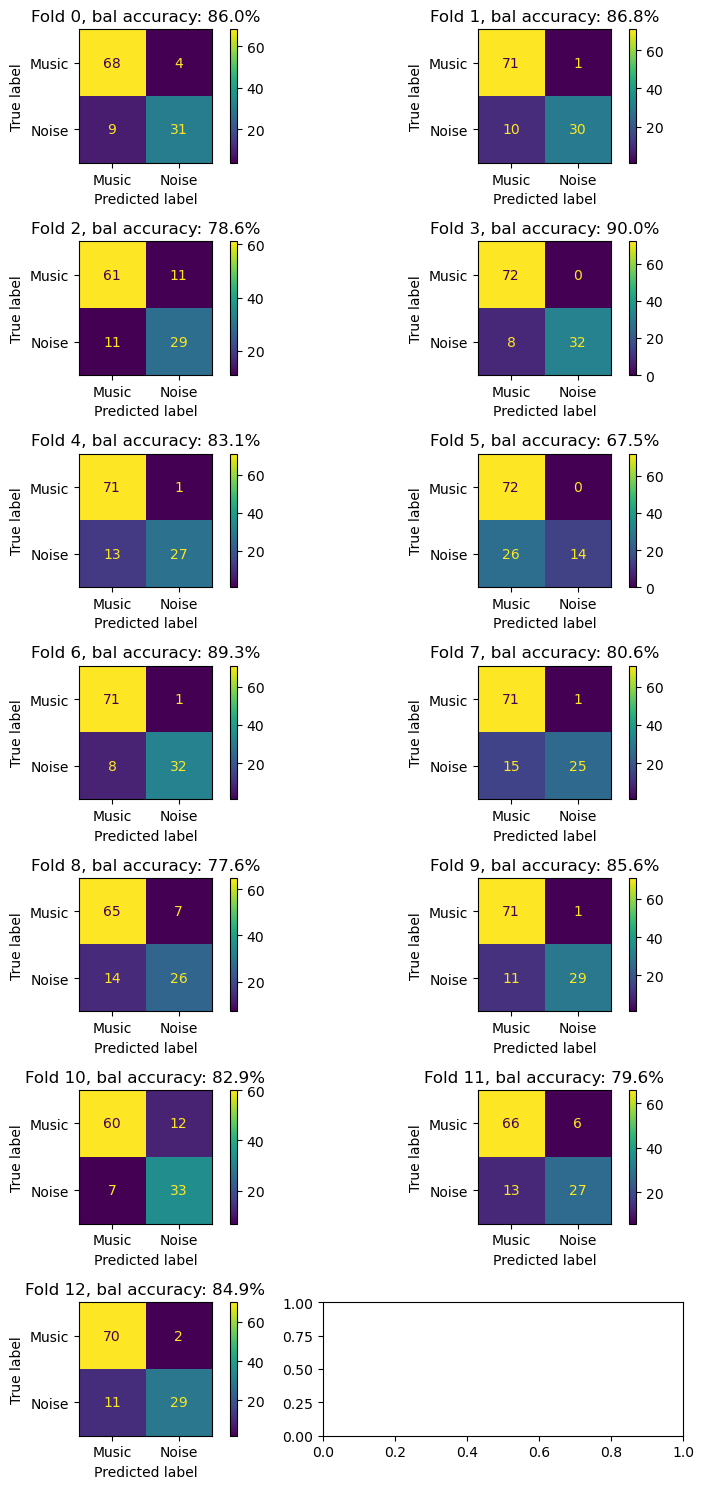

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

n_folds = 13
acc_array = np.zeros(n_folds)
acc_bal_array = np.zeros(n_folds)

fig, ax = plt.subplots(7, 2, figsize=(8, 15))

for ff in range(n_folds):
    # split the data into training and test set
    train_mask = chunks != ff+1
    test_mask = chunks == ff+1

    X_train = samples[train_mask]
    y_train = labels[train_mask]
    X_test = samples[test_mask]
    y_test = labels[test_mask]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Compute the prediction accuracy for the different labels
    acc_array[ff] = (y_pred == y_test).mean()
    acc_bal_array[ff] = balanced_accuracy_score(y_test, y_pred)

    # Confusion matrix plots
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax[ff // 2, ff % 2])
    ax[ff // 2, ff % 2].set_title(f"Fold {ff}, bal acc: {acc_bal_array[ff]*100:0.1f}%")

plt.tight_layout()


In [49]:
print(f"Mean accuracy: {acc_array.mean()*100:0.1f}% \u00B1 {acc_array.std()*100:0.1f}%")
print(f"Mean balanced accuracy: {acc_bal_array.mean()*100:0.1f}% \u00B1 {acc_bal_array.std()*100:0.1f}%")

Mean accuracy: 86.1% ± 4.7%
Mean balanced accuracy: 82.5% ± 5.7%


# LEGACY TESTS

In [28]:
# Perform the cross validation (takes time to compute)
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, cross_validate
cv_scores = cross_validate(estimator=clf,
                            X=samples,
                            y=labels,
                            groups=chunks,
                            cv=LeaveOneGroupOut(),
                            n_jobs=6,
                            return_estimator=True,
                            return_train_score=True,
                            return_indices=True,
                            verbose=1)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual

In [29]:
cv_scores

{'fit_time': array([3.89247632, 3.74709606, 3.78253317, 3.90937805, 3.9557898 ,
        3.79215407, 3.82179809, 3.82593322, 3.75015402, 4.09517789,
        3.83572984, 3.93715096, 3.79138803]),
 'score_time': array([0.00242686, 0.00202298, 0.00190592, 0.0026648 , 0.00247431,
        0.00236106, 0.00196505, 0.00187588, 0.00187802, 0.00165582,
        0.00180101, 0.00176191, 0.00162506]),
 'estimator': [LinearSVC(class_weight='balanced'),
  LinearSVC(class_weight='balanced'),
  LinearSVC(class_weight='balanced'),
  LinearSVC(class_weight='balanced'),
  LinearSVC(class_weight='balanced'),
  LinearSVC(class_weight='balanced'),
  LinearSVC(class_weight='balanced'),
  LinearSVC(class_weight='balanced'),
  LinearSVC(class_weight='balanced'),
  LinearSVC(class_weight='balanced'),
  LinearSVC(class_weight='balanced'),
  LinearSVC(class_weight='balanced'),
  LinearSVC(class_weight='balanced')],
 'indices': {'train': (array([ 112,  113,  114, ..., 1453, 1454, 1455]),
   array([   0,    1,    2, .

In [18]:
print('Average accuracy = %.02f percent\n' % (cv_scores.mean() * 100))
print('Accuracy per fold:', cv_scores, sep='\n')


Average accuracy = 86.06 percent

Accuracy per fold:
[0.88392857 0.90178571 0.80357143 0.92857143 0.875      0.76785714
 0.91964286 0.85714286 0.8125     0.89285714 0.83035714 0.83035714
 0.88392857]


# Other tests

In [12]:
from time import time

import matplotlib.pyplot as plt
from scipy.stats import loguniform

from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [18]:
X = samples
y = labels
y_bin = np.array([1 if l == 'Music' else 0 for l in y])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_bin, test_size=0.25, random_state=42
)

In [21]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10, n_jobs=4
)
clf = clf.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set


/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


done in 194.845s
Best estimator found by grid search:
SVC(C=1377.0576710547107, class_weight='balanced', gamma=0.000500745550932282)


Predicting people's names on the test set
done in 7.559s
              precision    recall  f1-score   support

       noise       0.00      0.00      0.00       131
       music       0.64      1.00      0.78       233

    accuracy                           0.64       364
   macro avg       0.32      0.50      0.39       364
weighted avg       0.41      0.64      0.50       364



/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

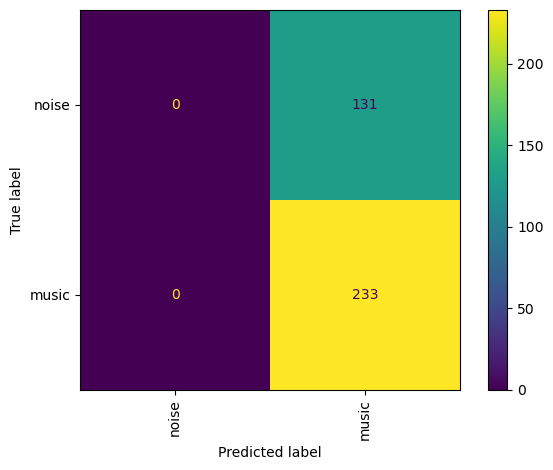

In [22]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test)
print("done in %0.3fs" % (time() - t0))
target_names = ["noise", "music"]

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

In [19]:
# import pandas as pd
# results1 = pd.DataFrame({'accuracy': cv_scores})
# results1.to_csv(os.path.join(dataset_dir, 'mvpa-lsa-musicnoise-confounds-gm-results-1.csv'), index=False)
# print('saved accuracy results to mvpa-musicnoise-confounds-gm-results-1.csv')

# # %%
# # Import the permuation function
# from sklearn.model_selection import permutation_test_score

# # %%
# # Run the permuation cross-validation
# null_cv_scores = permutation_test_score(estimator=clf,
#                                         X=samples,
#                                         y=labels,
#                                         groups=chunks,
#                                         cv=LeaveOneGroupOut(),
#                                         n_permutations=1000,
#                                         n_jobs=30,
#                                         verbose=1)

# # %%
# print('Prediction accuracy: %.02f' % (null_cv_scores[0] * 100),
#       'p-value: %.04f' % (null_cv_scores[2]),
#       sep='\n')

# # %%
# results2 = pd.DataFrame({'accuracy': null_cv_scores})
# results2.to_csv(os.path.join(dataset_dir, 'mvpa-lsa-results-2.csv'), index=False)
# print('saved accuracy results to mvpa-lsa-results-2.csv')
print('python script finished running.')

python script finished running.
